## Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

##### Read data

In [2]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (20937, 34)


,Posted Time,Longitude,Latitude,Area,Width,Length,Floors,Rooms,Toilets,Price per m2,...,House Direction_SOUTHWEST,House Direction_WEST,Furnishing Sell_BASIC_FINISHING,Furnishing Sell_FULLY_FURNISHED,Furnishing Sell_HIGH_END_FURNITURE,Furnishing Sell_RAW_HANDOVER,Land Type_AGRICULTURAL_LAND,Land Type_INDUSTRIAL_LAND,Land Type_PROJECT_LAND,Land Type_RESIDENTIAL_LAND
0,2025-01-31,10.400602,4.003590,10.000000,2.236068,4.472136,0.0,0.0,0.0,1.581139,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2025-02-01,10.398891,4.009621,10.000000,2.236068,4.472136,0.0,0.0,0.0,1.581139,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2025-01-13,10.399521,4.008289,8.660254,2.236068,3.872983,0.0,0.0,0.0,1.932184,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2025-02-07,10.400602,3.996527,12.369317,2.236068,5.477226,0.0,0.0,0.0,1.646942,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2025-02-02,10.397751,4.005646,10.000000,2.236068,4.472136,0.0,0.0,0.0,2.236068,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Create time feature

In [3]:
df['year']      = df['Posted Time'].dt.year
df['month']     = df['Posted Time'].dt.month
df['day']       = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter']   = df['Posted Time'].dt.quarter
# Mùa xuân (tháng 1-3), Mùa hè (tháng 4-6), Mùa thu (tháng 7-9), Mùa đông (tháng 10-12)
# season_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}
# df['season'] = df['month'].map(season_dict)
# cyclical features

df.drop(columns=['Posted Time'], inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20937 entries, 0 to 20936
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Longitude                           20937 non-null  float64
 1   Latitude                            20937 non-null  float64
 2   Area                                20937 non-null  float64
 3   Width                               20937 non-null  float64
 4   Length                              20937 non-null  float64
 5   Floors                              20937 non-null  float64
 6   Rooms                               20937 non-null  float64
 7   Toilets                             20937 non-null  float64
 8   Price per m2                        20937 non-null  float64
 9   1 Part Residential                  20937 non-null  int64  
 10  All Residential                     20937 non-null  int64  
 11  Back Expansion                      20937

#### EDA: Correlation matrix

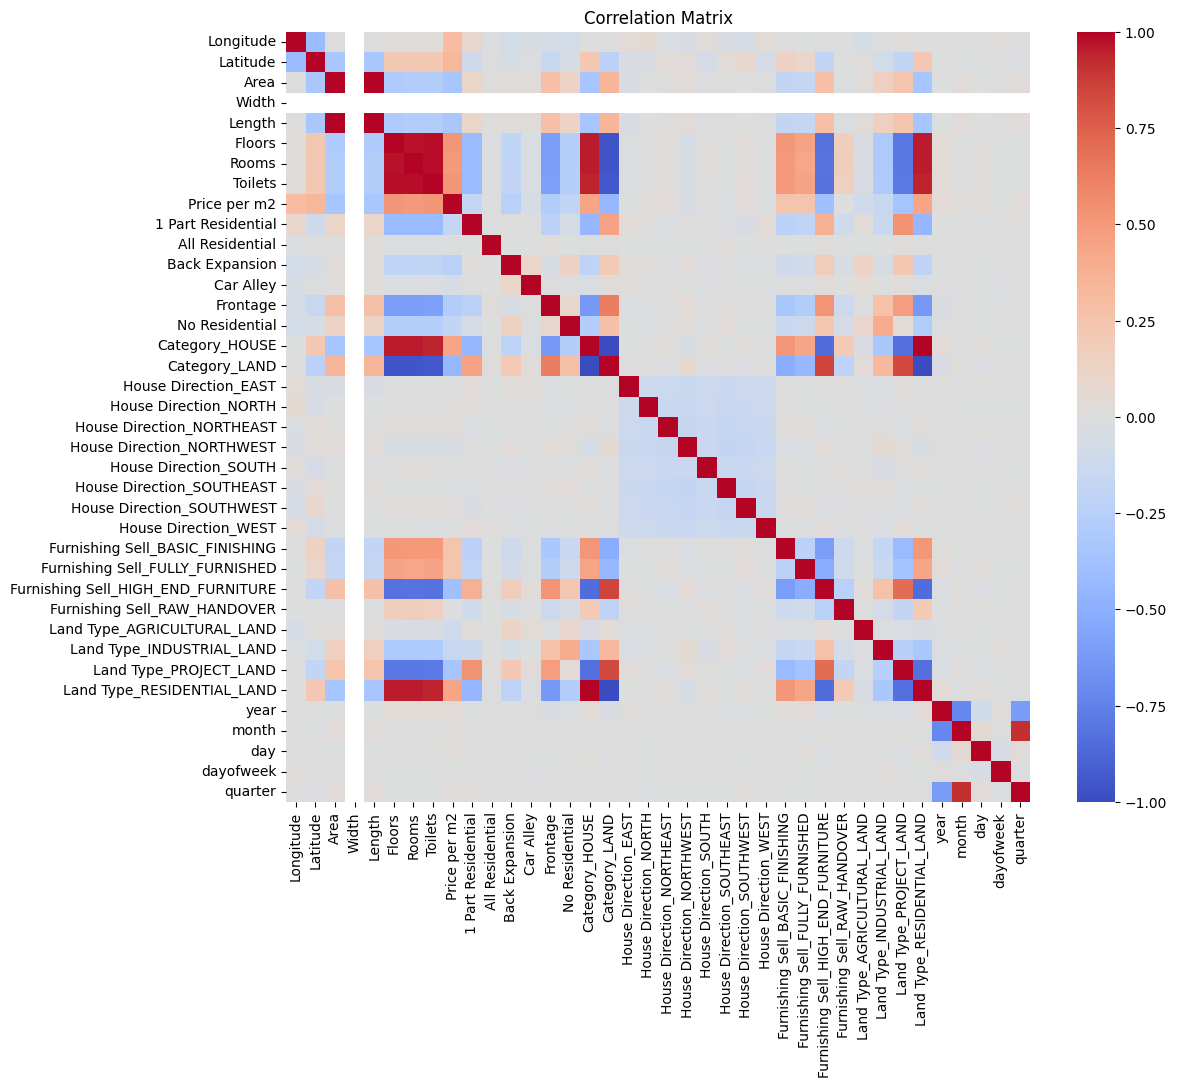

Top 10 features correlated with Price per m2:
 Floors                                0.517523
Toilets                               0.516485
Rooms                                 0.493847
Category_LAND                         0.443516
Category_HOUSE                        0.443516
Land Type_RESIDENTIAL_LAND            0.443516
Furnishing Sell_HIGH_END_FURNITURE    0.389836
Land Type_PROJECT_LAND                0.357008
Area                                  0.345135
Length                                0.342874
Name: Price per m2, dtype: float64


In [4]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.show()

corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

#### Split data

In [5]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# X_train = train.drop('Price per m2', axis=1)
# y_train = train['Price per m2']
# X_test = test.drop('Price per m2', axis=1)
# y_test = test['Price per m2']

# print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (16749, 37), X_test: (4188, 37)


### Train model

In [6]:
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 0.9, 1.0, 5.0, 10.0, 50.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_model = Ridge(**best_params)
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best parameters: {'alpha': 0.01, 'solver': 'auto'}


Ridge(alpha=0.01)

#### Evaluate

In [7]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Ridge Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")

=== Ridge Evaluation ===
Training MSE: 1.38571, RMSE: 1.17716, MAE: 0.86146, R2: 0.5898
Test MSE: 1.43708, RMSE: 1.19878, MAE: 0.87002, R2: 0.5670


#### Scatter actual vs predicted

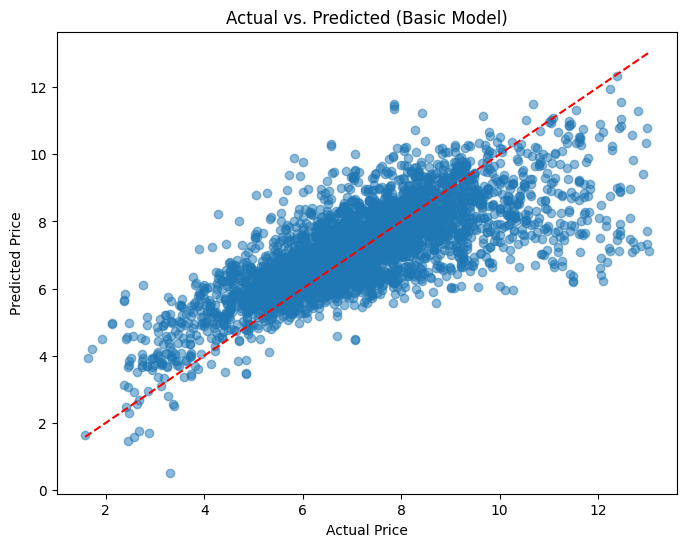

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted (Basic Model)")
plt.show()

#### Feature importance

#### Error distribution

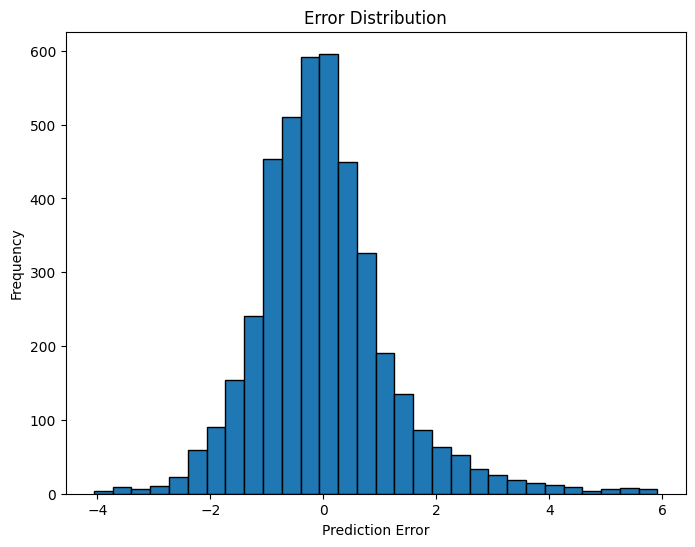


Cross-val MSE mean: 1.40145, std: 0.06060


In [9]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.show()

# 11. Cross-validation trên train
cv_scores = cross_val_score(best_model, X_train, y_train,
                            cv=5, scoring='neg_mean_squared_error')
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))


#### Fit final model on full dataset

#### Export model

In [10]:
# Save the model in pickle format
with open('ridge_regression_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Ridge model saved to 'ridge_regression_model.pkl'")

Ridge model saved to 'ridge_regression_model.pkl'


In [ ]:
from sklearn.linear_model import Ridge
from sklearn2pmml import sklearn2pmml, PMMLPipeline
import pandas as pd

# Giả sử bạn đã có X_train (DataFrame) và y_train
pipeline = PMMLPipeline([
    ("regressor", Ridge(alpha=1.0))  # có thể thay alpha tùy theo model đã chọn
])

# Huấn luyện mô hình
pipeline.fit(X_train, y_train)

# Xuất mô hình ra file PMML
sklearn2pmml(pipeline, "ridge_regression_model.pmml", with_repr=True)
print("Ridge Regression model saved as PMML format: 'ridge_regression_model.pmml'")


### Test model

In [11]:
base = X.iloc[-10].copy()

# Ngày bắt đầu forecast: hôm nay (chỉ lấy phần date)
start_date = pd.Timestamp.now().normalize()

results = []
for i in range(730):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Cập nhật các feature thời gian
    f['year']      = date.year
    f['month']     = date.month
    f['day']       = date.day
    f['dayofweek'] = date.weekday()
    f['quarter']   = date.quarter
    # f['season']    = season_dict[date.month]
    
    # Dự đoán
    X_pred = f.values.reshape(1, -1)
    pred_price = best_model.predict(X_pred)[0]
    original_price = np.exp(pred_price)

    results.append({
        'Date': date,
        'Predicted_Price_per_m2': original_price
    })

forecast_df = pd.DataFrame(results)

print(forecast_df.head())
print(forecast_df.tail())


        Date  Predicted_Price_per_m2
0 2025-06-12             3008.985718
1 2025-06-13             3008.728590
2 2025-06-14             3008.471484
3 2025-06-15             3008.214400
4 2025-06-16             3087.510363
          Date  Predicted_Price_per_m2
725 2027-06-07            22649.379518
726 2027-06-08            22647.444050
727 2027-06-09            22645.508747
728 2027-06-10            22643.573610
729 2027-06-11            22641.638638


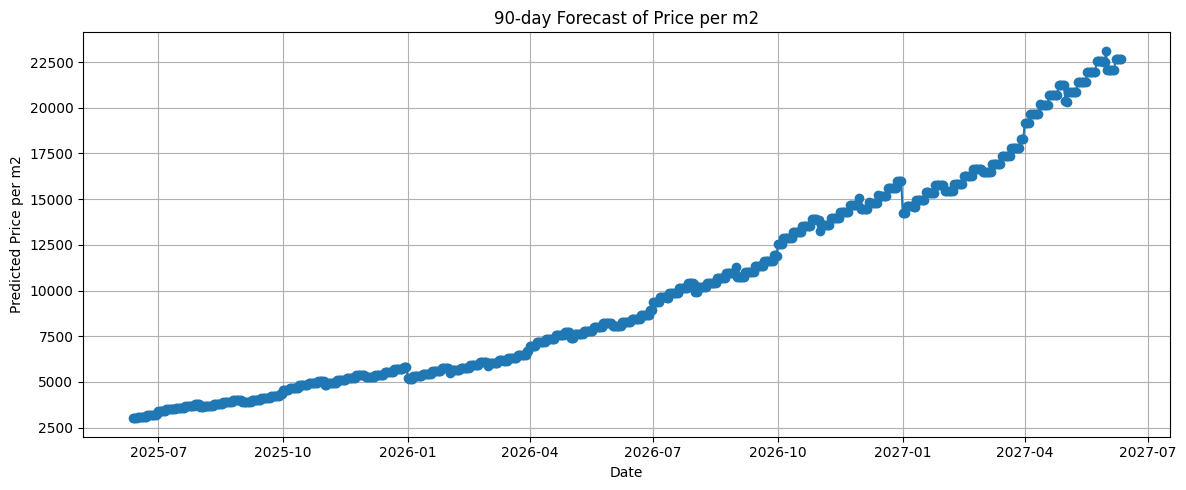

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], marker='o')
plt.title('90-day Forecast of Price per m2')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()